In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
from matplotlib import rcParams
from cycler import cycler

# -- Figure size --
# rcParams['figure.figsize'] = (12, 4)
# -- Saving Options --
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True
# -- Plot Styles --
rcParams['lines.linewidth'] = 0.3
teal = (106 / 256, 197 / 256, 179 / 256)
navy = (56 / 256, 74 / 256, 143 / 256)
pink = [199 / 255, 99 / 255, 150 / 255]
rcParams['axes.prop_cycle'] = cycler(color=[teal, navy, pink])

In [56]:
from tqdm.notebook import tqdm

In [57]:
import nltk

In [58]:
def save_plot(title):
  plt.ylabel('')
  plt.savefig(f'{title}.pdf', dpi=300, bbox_inches='tight')

In [59]:
df = pd.read_csv('dataset/HODI_2023_train_subtaskA.tsv', sep='\t').drop(columns=['id'])

In [60]:
df.head()

,text,homotransphobic
0,Hanno rotto le #palle con i €compleanni a #dop...,0
1,"@user_abc Avete rotto,come potete prendere se ...",0
2,Guevara si è rotto il cazzo e ha mandato a far...,0
3,@user_abcd Se io volessi entrare in un bar con...,0
4,@user_abcdef @user_abc @user_abcdefgh Ok nessu...,0


In [12]:
df.shape

(5000, 2)

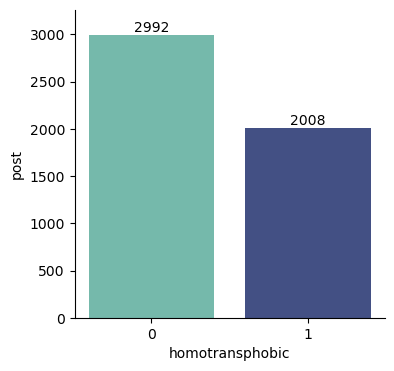

In [102]:
target_variable = 'homotransphobic'

plt.figure(figsize=(4, 4))
ax = sns.countplot(data=df, x=target_variable)

ax.bar_label(ax.containers[0]) # per i numeri sopra le barre
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.margins(0.05, 0.09) # per i margini dei numeri dal bordo in alto
plt.ylabel('post')
plt.savefig(f'img/{target_variable}_distribution_bar.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
value_perc = df[target_variable].value_counts(normalize=True)*100

print(f'{float(value_perc[0]):.0f}% of the dataset is {target_variable}')
print(f'{float(value_perc[1]):.0f}% of the dataset is not {target_variable}')

60% of the dataset is homotransphobic
40% of the dataset is not homotransphobic


In [9]:
import re

def text_cleaner(text, lowercase=True, r_emoticons=True):

    clean_text = re.sub(r'@\w+ ', '', text) # remove @word
    clean_text = re.sub(r'[\n\r_]', ' ', clean_text) # remove new line, tab, return, space
    clean_text = re.sub(r'\*+?', '', clean_text)
    clean_text = re.sub(r'\d\d/\d\d/\d\d', '', clean_text) # remove date
    clean_text = re.sub(r'\[URL\]', '', clean_text) # remove [URL]
    
    if r_emoticons:
        clean_text = re.sub(r'[^a-zA-Z0-9 \\/\.\'\",:-;!\?\(\)-ìèéòóàùÈ\&%=]', '', clean_text)
    
    if lowercase:
        clean_text = clean_text.lower()
    
    
    return clean_text.strip()

In [10]:
df_clean = df.copy() 
df_clean['text'] = df['text'].apply(text_cleaner)
df_clean

,text,homotransphobic
0,hanno rotto le palle con i compleanni a doppio...,0
1,"avete rotto,come potete prendere se le pubblic...",0
2,guevara si è rotto il cazzo e ha mandato a far...,0
3,se io volessi entrare in un bar con una trombe...,0
4,ok nessuno discute ciò ma 2 passetti avanti e ...,0
...,...,...
4995,questa volta perderete molti consensi voi che ...,1
4996,quando la russia ti piglia per il culo e la ue...,0
4997,stai zitto coglione e fatti bombardare da puti...,1
4998,lesbiche? non lo so. per me sono solo delle sq...,0


In [11]:
np.where(df_clean.applymap(lambda x: x == '')) # ci sono stringhe vuote? 

(array([], dtype=int64), array([], dtype=int64))

In [14]:
# export dataset to csv
df_clean.to_csv('dataset/df_train_clean.csv', index=False)

## Word Cloud

### distribuzione parole

In [15]:
import re
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elenascaglione/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/elenascaglione/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
punteggiatura = ['.', ',', ':', ';', '?', '!', '--', '-', '(', ')', '``', "''", '#', '$', '[', ']', '``', '_', "''", '*', '...']

In [17]:
tokens = list()

for row in df_clean.text:
    tokens_sent = nltk.word_tokenize(row)
    for token in tokens_sent:
      if not token.isnumeric() and token not in punteggiatura:
        tokens.append(token)

    #tokens += tokens_sent

print('tokens:', len(tokens),
      '\nvocabulary:', len(set(tokens)),
      '\nTTR:', len(set(tokens))/len(tokens))

tokens: 114525 
vocabulary: 17320 
TTR: 0.15123335516262826


In [18]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('italian'))

def clean_text(text, lower=False):
    """ text: a string
        return: modified initial string """
    if lower:
      text = text.lower() # lowercase text
    text = re.sub(r'[/(){}\[\]\|@,;]', ' ', text) # substitute the matched string with space.
    text = re.sub(r'[#+_]', '', text) # substitute bad symbols with nothing.
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_clean['text'] = df_clean['text'].apply(clean_text)

## wordcloud

In [20]:
from wordcloud import WordCloud, ImageColorGenerator

In [21]:
homotransphobic_msg_text = ''
for homotransphobic_post in list(df_clean[df_clean[target_variable] == 1].text):
    homotransphobic_msg_text += homotransphobic_post

homotransphobic_msg_text

'orrore utero affitto delirio marzano: «è giusto fare bambini darli "mammi" gay»allora situazione qui critica trema culo vedere najwa vestita daddy mommy clamorosa sfondata soldi ogni caso cosa certa: frocia merdave l\'ho mai detto gay schiforiesco riprendermi video pupilli destra frocia cantano quel coro stadio meloni sculettante trucco parrucco dentiera nuovi dato testacenato massone omosessuale andreaindini de ilgiornale. andrea indini fa parte massoneria nazista gay gioelemagaldi gioele magaldi! m\'ha detto "marinaberlusconi ordinato fingere d\'esser putin vogliamo putin uccida tutti"rt sbirdi nera frocia nerafrocia sbirdisbirdsbirsbisbsfinito bonus culo rotto conquesta partita..nelle prossime 3 mala pena 4 punti..noi pareggiandone vincendo due casa cuciremo seconda stella punto più.sai riderevabbè proprio rincoglionito rotto culo trimonazzo merda bastardo ignorante capra puzzolente schifoso cuozzo bohvivi male calcio eh maledetto rotto culoinstagram dato grasso fino punto devo sop

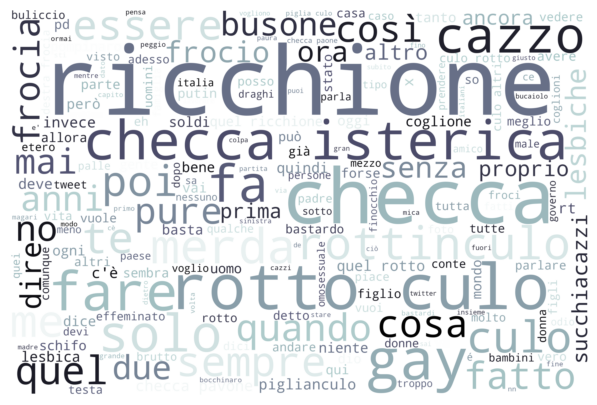

In [53]:
msg_cloud = WordCloud(width=3000, 
                      height=2000, 
                      stopwords=STOPWORDS, 
                      # max_font_size=50, 
                      background_color = "white", 
                      # max_words=100,
                      colormap = 'bone'
                      ).generate(homotransphobic_msg_text)

def black_color_func(word, font_size, position,orientation,random_state = None, **kwargs):
    return("hsl(0,100%, 1%)")

# set the word color to black
# msg_cloud.recolor(color_func = black_color_func)

plt.figure(figsize=(10,5))
plt.imshow(msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.savefig('img/wordcloud_homotransphobic.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
non_homotransphobic_msg_text = ''
for non_homotransphobic_post in list(df_clean[df_clean[target_variable] == 0].text):
    non_homotransphobic_msg_text += non_homotransphobic_post

non_homotransphobic_msg_text

'rotto palle compleanni doppio leoanrdo cioè leoanrdo doppio ossia leo nardo leo nata nardo pure gay exprete salesiani montinaro amico leccise va nardo oltre aliciccinesi merrsgnez disabilirotto potete prendere pubblicità fate tutte negative tolto stato demergenza sanitario vergognosi tornassero indietro nonni calci culo devono prendereguevara rotto cazzo mandato fare culo masia. incredibile capace mettere d\'accordo mondo dovremmo averlo presidente contrario. spanishgp moto3volessi entrare bar trombetta culo levo? rotto palle vaccini ringraziato milioni persone vaccinate ora vuol tenere mascherina cazzi propri ridire? fanculook nessuno discute ciò 2 passetti avanti 4 indietro lì vogliamo fare? allungamento catene valore: cazzata. vedendo subendo effetti piglia culo. monoprodotto naveline x es. biodiversità tutela pianeta varie eventuali &gtragazzi giovani mai vinto niente vero problema spero caghino sotto già avvenuto passato peccatoconversations fratellidindrangheta grido battaglia è

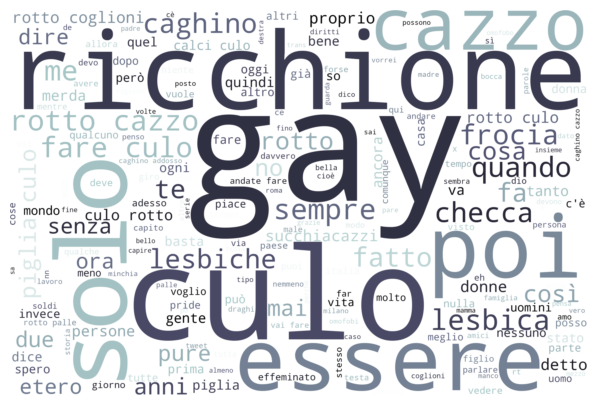

In [52]:
msg_cloud = WordCloud(width=3000, 
                      height=2000, 
                      stopwords=STOPWORDS, 
                      # max_font_size=50, 
                      background_color = "white", 
                      # max_words=100,
                      colormap = 'bone'
                      ).generate(non_homotransphobic_msg_text)

# set the word color to black
# msg_cloud.recolor(color_func = black_color_func)

plt.figure(figsize=(10,5))
plt.imshow(msg_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.savefig('img/wordcloud_non_homotransphobic.pdf', dpi=300, bbox_inches='tight')
plt.show()